In [22]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('summer_internship_takehome.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996 entries, 0 to 3995
Data columns (total 9 columns):
Location number       3996 non-null int64
Month                 3996 non-null int64
State                 3996 non-null object
Gross revenue         3996 non-null float64
Fixed cost            3996 non-null float64
Variable cost         3996 non-null float64
Rental cost           3996 non-null int64
Number of products    3996 non-null int64
Owned                 3996 non-null bool
dtypes: bool(1), float64(3), int64(4), object(1)
memory usage: 253.8+ KB


In [4]:
df.head(10)

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False
5,1,6,TX,50677036.26,9763597.30,26233794.37,365880,4452,False
6,1,7,TX,28215465.22,8245679.54,14457234.12,365880,4452,False
7,1,8,TX,38955413.84,7863853.69,19744464.29,365880,4452,False
8,1,9,TX,43602895.19,9067861.36,22138203.51,365880,4452,False
9,1,10,TX,52406102.98,9062239.73,26246199.30,365880,4452,False


In [7]:
#calculating profit margin 
df['profit_margin'] = df['Gross revenue'] - (df['Fixed cost'] + df['Variable cost'] + df['Rental cost'])

In [20]:
#finding mean 
df.groupby('Location number').mean()['profit_margin']

Location number
1      1.250700e+07
2      7.382227e+06
3      6.887182e+06
4      4.578624e+06
5      3.300148e+06
           ...     
329    4.909681e+06
330    7.221269e+06
331    7.348921e+06
332    8.841392e+06
333    1.516013e+07
Name: profit_margin, Length: 333, dtype: float64

In [21]:
#finding median 
df.groupby('Location number').median()['profit_margin']

Location number
1      1.240631e+07
2      6.810856e+06
3      7.159085e+06
4      4.262322e+06
5      3.502488e+06
           ...     
329    4.860603e+06
330    7.257015e+06
331    7.707798e+06
332    9.203179e+06
333    1.535170e+07
Name: profit_margin, Length: 333, dtype: float64

In [24]:
#distribution histogram
def histogram(df):
    fig,ax = plt.subplots(figsize=(10,10))
    n,bins,patches = ax.hist(df, 40, density=1, facecolor='blue', alpha=0.5, edgecolor='black')

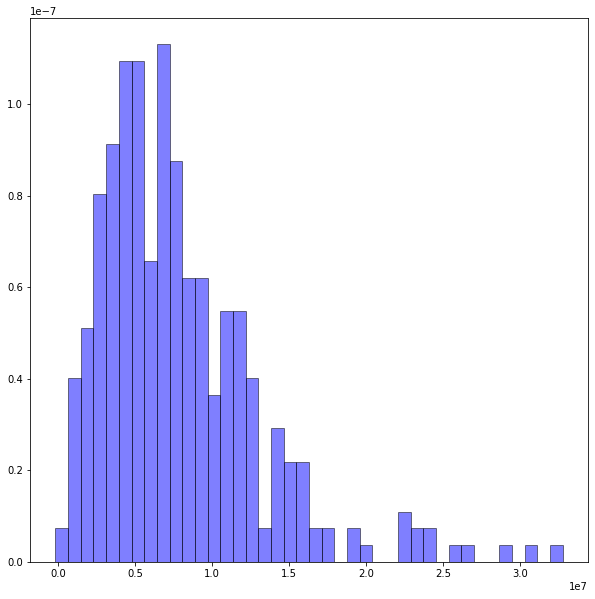

In [25]:
#distribution of median profit margin
histogram(df.groupby('Location number').median()['profit_margin'])

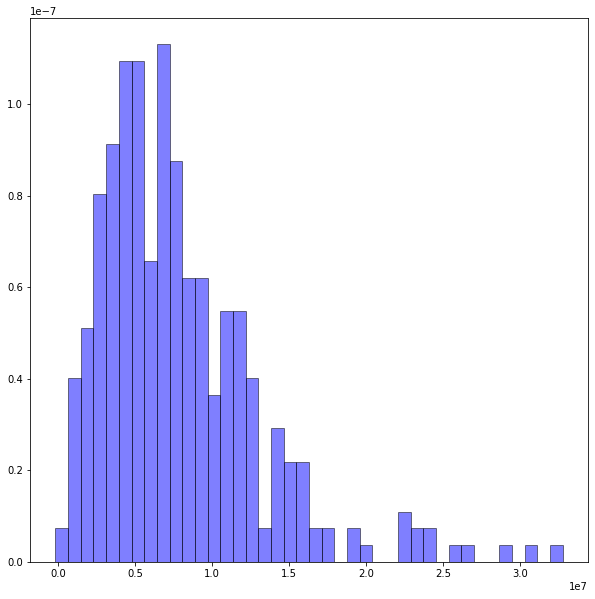

In [26]:
#distribution of median profit margin
histogram(df.groupby('Location number').median()['profit_margin'])